# ReLU && Optimizer

## sigmoid의 문제점

#### sigmoid를 activation function으로 사용한다면 어떻게 될까?

- weight, input를 이용한 sigmoid함수로 output을 구한다. 
- 실제 정답과의 차이를 이용해 Loss를 구한다. 
- Loss를 미분하여 gradient를 구한다. 
- back propagation을 이용해 weight를 업데이트 한다. 

#### 무엇이 문제일까? 

- gradient를 구할 때 문제가 된다. 
- sigmoid함수 그래프를 보면 이해가 쉬워진다. 

![sigmoid](../statics/image/sigmoid.jpg)

- x가 0에 가까울수록 gradient가 확연하게 바뀐다. 
- 양 끝의 경우, 소수점 뒤의 수만 작게 변하게 된다. 
- 문제는, back propagation을 이용해 gradient를 전파하고 activation function에서 전파받은 gradient가 무의미해진다(vanishing gradient)
- sigmoid함수를 이용하는 레이어가 중첩될수록 더 큰 영향을 끼치게 된다. 

#### ReLU는 무엇이 다르길래 괜찮은걸까?

`f(x) = max(0, x)`

- ReLU는 0보다 작으면 무조건 0을, 크면 x를 그대로 반환한다. 
- x > 0 일 경우, gradient는 항상 1이다. 
- 음수의 영역에선 gradient가 항상 0이기 떄문에, 음수의 x에 대해선 vanishing gradient가 여전히 발생한다. 
- pytorch에서는 `torch.nn.relu(x)`를 이용한다. 

#### 다양한 활성화 함수

- sigmoid
    - 우리가 아는 그것. 1 / (1 + e^(-x))
- tanh
    - (e^x - e(-x)) / (e^x + e^(-x))
    - sigmoid보다 출력 중심이 0이라 성능을 개선할 수 있다. 
    - vanishing gradient가 여전히 존재한다. 
- relu
    - 현재 가장 상용화되어있으며, 양수인 x에 항상 사용 가능하다. 
    - 입력이 0보다 작으면 dead neuron이 발생할 수 있다. 
- leaky_relu
    - f(x) = max(ax, x) a에 따라 음수의 영역에서도 아주 작게나마 gradient를 가진다. 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# 데이터 준비
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [16]:
# 결과 저장
results = {}

# 모델 정의
class SimpleNet(nn.Module):
    def __init__(self, activation):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(2, 16)
        self.activation = activation
        self.layer2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        return self.layer2(x)

In [17]:
# 활성화 함수 리스트
activations = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(0.1)
}

In [18]:
# 학습 루프
def train_model(act_name, activation):
    model = SimpleNet(activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_losses = []
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # 평가
    with torch.no_grad():
        preds = torch.argmax(model(X_test), axis=1)
        acc = (preds == y_test).float().mean().item()

    results[act_name] = {
        "model": model,
        "losses": train_losses,
        "accuracy": acc
    }

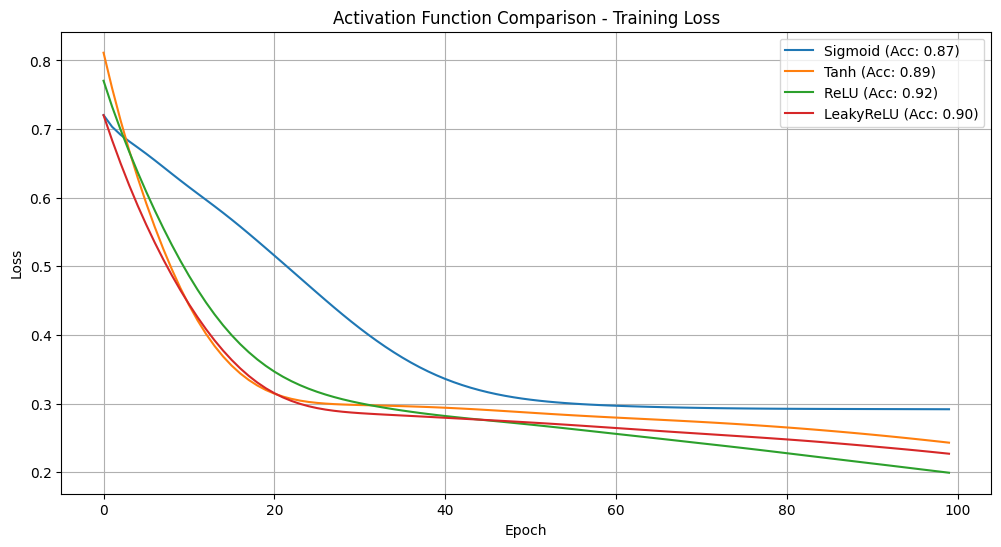

In [19]:
# 학습 실행
for name, act in activations.items():
    train_model(name, act)

# 결과 시각화
plt.figure(figsize=(12, 6))
for name in activations.keys():
    plt.plot(results[name]["losses"], label=f'{name} (Acc: {results[name]["accuracy"]:.2f})')
plt.legend()
plt.title("Activation Function Comparison - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Optimizer

- 손실함수의 값을 줄이기 위해 가중치를 어떻게 업데이트할까?를 결정하는 역할
- torch.optim에 optimizer가 다양하게 존재한다. 

#### 최적화 알고리즘의 종류
- torch.optim.SGD(Stochastic Gradient Descent)
    - 한 번에 하나의 샘플 데이터를 이용한다. 
    - 간단하다
    - 학습 튜닝이 필요하며, 수렴까지 오래걸릴 수 있다. 
- torch.optim.Adagrad
    - 과거 기울기를 누적해 learning rate를 자동 조정한다.  
    - 학습 데이터가 적을 때 효과적이다. 
    - lr이 점점 0에 수렴하여 학습을 멈출 수 있다. 
- torch.optim.Adadelta
    - Adadelta를 개선하여, learning rate를 0이 되지 않도록 RMS기반 조정을 수행한다.( Root Mean Square : 기울기 제곱의 평균값의 루트)
    - learing rate를 튜닝할 필요가 없다. 
    - 구조가 복잡하다.
- torch.optim.RMSprop
    - Adadelta와 유사하다. 최근 기울기에 더 큰 가중치를 둬 학습률을 조정한다. 
    - RNN에 강하다. (RNN이 뭘까?)
    - 모멘텀 조합이 필요할 수 있다. (모멘텀이 뭘까?) 
- torch.optim.Adam
    - 모멘텀 + RMSprop조합으로, 가장 널리 사용된다.
    - 수렴이 빠르고 튜닝이 거의 필요 없다. 
    - 간혹 촤솟값 근처에서 진동형 변동이 일어난다. (와리가리)
- torch.optim.Adamax
    - Adam 변형으로, 무한노름기반 안정화된 버전이다. (무한노름이 뭘까?)  
    - 고차원 공간에 최적화되어있다. 
    - 일반 Adam보다 사용 빈도가 낮다. 
- torch.optim.SparseAdam
    - sparse tensor용 Adam이다. (sparse tensor가 뭘까?)
    - 회소 벡터 최적화에 강하다. 
    - Dense에는 부적합하다. (Dense가 뭘까?)
- torch.optim.ASGD
    - 평균 파라미터를 이용한 SGD의 변형버전
    - 수렴 안정성이 증가한다. 
    - 잘 안쓴다. 
- torch.optim.LBFGS
    - 2차 최적화(준 뉴턴 방식), 배치 전체 기반 (준 뉴턴방식이 뭘까?)
    - 작은 모델에선 빠른 수렴을 할 수 있다. 
    - 메모리 부하가 크고, 미니배치에 부적합하다
- torch.optim.Rprop
    - 기울기 크기 무시하고 방향만을 이용한다(단위 벡터 쓰는건가?)
    - 고정된 step size 기반이다. 
    - SGD보다 느리고, 잘 쓰지 않는다. 

공부하다보니, 또 다른 모르는 단어들이 나왔다. 한번 찾아봐야겠다. 

- RNN
    - 순환 신경망
    - 추후 강의로 존재하니 그때 공부해도 괜찮을 듯 하다
- 모멘텀
    - 관성의 개념을 도입한 최적화 알고리즘
    - SGD에서 다음 스텝의 최적화 알고리즘을 계산할 때 마다 이전 스텝의 이동방향을 일정 비율로 이어가며 관성을 적용
    - 일련된 방향으로는 빠르게 이동하며 진동형으로 발생하는 그래프를 억제할 수 있다. 
    - RMSprop에서 각 파라미터의 learing rate를 적절히 조절하지만 기울기의 방향성에 대한 누적 정보가 존재하지 않는다. 
    - 이로 인해 진동형 그래프가 발생할 수 있고, 이를 방지하기 위해 모멘텀을 조합하여 사용한다. 
- 무한노름
    - 벡터의 각 원소의 절대값중 가장 큰 값
    - 이를 통해 상한을 억제할 수 있다. 
    - 위에서 `무한 노름 기반 안정화 기법`이라는 건 최대값을 제한해 전체 시스템의 불안정성을 줄이는 기법
- sparse tensor
    - 희소 텐서
    - 대부분이 원소가 0으로 되어있을 경우, 해당 0의 값이 어디있는지를 따로 정리하여 저장한다. 
    - sparse tensor의 경우 행렬의 크기, 0이 아닌 원소의 인덱스와 값을 저장한다. 
- Dense(위에 있음)
- 준 뉴턴 방식
    - 비선형 모델에 대한 최적화 알고리즘중 하나로 뉴턴방법을 일부 활용한다. 
    - 뉴턴 방식
        - x_(k+1) = x_k - H^(-1) d( f(x_k) ) / dx
        - 현재 위치 x_k의 기울기와 이차미분 행렬의 역행렬을 곱해 현재 위치 x_k에서 빼는 식으로 가중치 최적화값을 계산한다. 
        - 헤시안 계산이 비용이 크거나 불가능할 수 있으며, 차원이 커질수록 계산량이 늘어난다.
    - 헤시안 계산
        - 헤시안 행렬이란 함수를 두 번 편미분한 값들의 행렬이다. 
        - 즉, 차원이 커질수록(변수의 종류가 많아지겠죠?) 편미분할 거리들이 많아지며 연산량이 증가하게 된다. 
    - 준 뉴턴 방식
        - 헤시안 계산을 직접 하지 않고 반복적으로 헤시안의 근사행렬을 업데이트하면서 최적화를 수행
        - x_(k+1) = x_k - B_k^(-1) * d( f(x_k) ) / dx
        - B_k는 헤시안의 근사행렬로, 매 반복마다 이전 기울기 정보들을 이용해 갱신한다.
        - DFP, BFGS, L-BFGS등의 방법이 있으며 BFGS가 가장 많이 쓰인다. 
- Rprop -> 기울기 크기를 무시하고 방향만을 이용하면 단위벡터화시킨걸까?
    - 단위벡터가 아닌, 기울기의 부호만 사용하며 크기는 자체적으로 조절시키는 학습모델이다. 

In [20]:
# 1. 데이터 생성
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [21]:
# 2. 모델 정의
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [22]:
# 3. 학습 함수
def train_model(optimizer_name, optimizer_class):
    model = SimpleNet()
    criterion = nn.BCELoss()
    optimizer = optimizer_class(model.parameters())
    val_losses = []

    for epoch in range(50):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 검증 손실 저장
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
            val_losses.append(val_loss)

    return val_losses

In [23]:
# 4. 옵티마이저 설정
optimizers = {
    "SGD": lambda params: torch.optim.SGD(params, lr=0.1),
    "Adagrad": lambda params: torch.optim.Adagrad(params, lr=0.1),
    "Adadelta": lambda params: torch.optim.Adadelta(params),
    "RMSprop": lambda params: torch.optim.RMSprop(params, lr=0.01),
    "Adam": lambda params: torch.optim.Adam(params),
    "Adamax": lambda params: torch.optim.Adamax(params),
    "ASGD": lambda params: torch.optim.ASGD(params, lr=0.01),
}

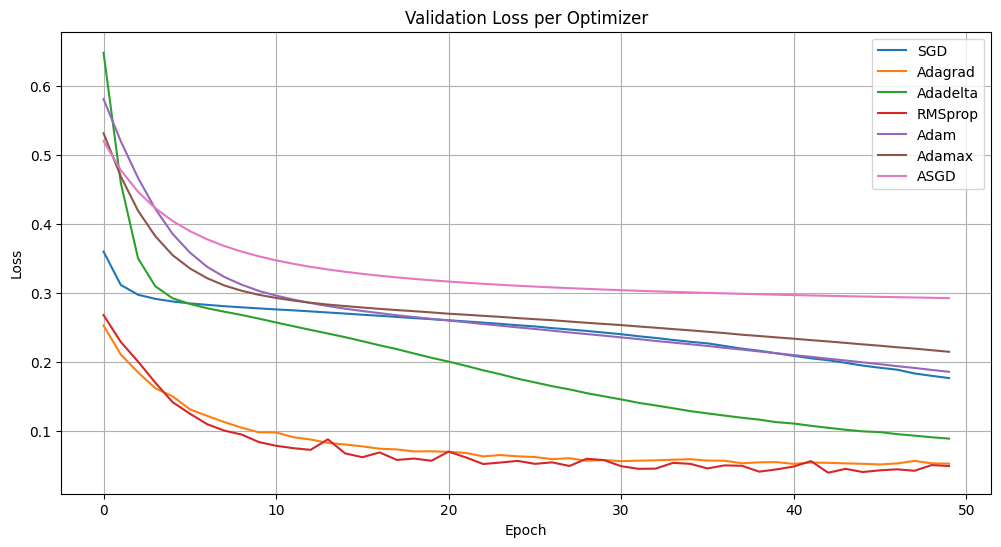

In [24]:
# 5. 결과 시각화
plt.figure(figsize=(12, 6))
for name, opt in optimizers.items():
    val_loss = train_model(name, opt)
    plt.plot(val_loss, label=name)

plt.title("Validation Loss per Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()